# Machine Scheduling

"Which job should be done next?" is a questiona one face in modern life, whetherfor a busy student working on course assignments, a courier delivering packages, a server waiting on tables in a busy restaurant, a computer processing threads, or a machine on a complex assembly line. There are empirical answers to this question, among them "first in, first  out", "last  in, first out", or "shortest job first".  

What we consider in this notebook is the modeling finding solutions to this class of problem using optimiziation techniques. This notebook demonstrates the formulation of a model for scheduling a single machine scheduling using disjuctive programming in Pyomo. The problem is to schedule a set of jobs on a single machine given the release time, duration, and due time for each job. Date for the example problem is from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 5, Dash Optimization, 2000.

In [1]:
# Import Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

## Learning Goals

* Optimal scheduling for a single machine
* Disjuctive programming in Pyomo

## Example

The problem is to schedule a sequence of jobs for a single machine. The problem data as a nested Python dictionary of jobs. Each job is labeled by a key. For each key there is an associated data dictionary giving the time at which the job is released to the for machine processing, the expected duration of the job, and the due date. The optimization objective is to find a sequence the jobs on the machine that meets the the due dates. If no such schedule exists, then the objective is to find a schedule minimizing some measure of "badness".

In [39]:
import pandas as pd

jobs = pd.DataFrame({
    'A': {'release': 2, 'duration': 5, 'due': 10},
    'B': {'release': 5, 'duration': 6, 'due': 21},
    'C': {'release': 4, 'duration': 8, 'due': 15},
    'D': {'release': 0, 'duration': 4, 'due': 10},
    'E': {'release': 0, 'duration': 2, 'due':  5},
    'F': {'release': 8, 'duration': 3, 'due': 15},
    'G': {'release': 9, 'duration': 2, 'due': 22},
}).T

jobs

,release,duration,due
A,2,5,10
B,5,6,21
C,4,8,15
D,0,4,10
E,0,2,5
F,8,3,15
G,9,2,22


## Gantt chart

A traditional means of visualizing scheduling data in the form of a Gantt chart. The next cell presents a function `gantt` that plots a Gantt chart given jobs and schedule information. If no schedule information is given, the jobs are performed in the order listed in the jobs dataframe.

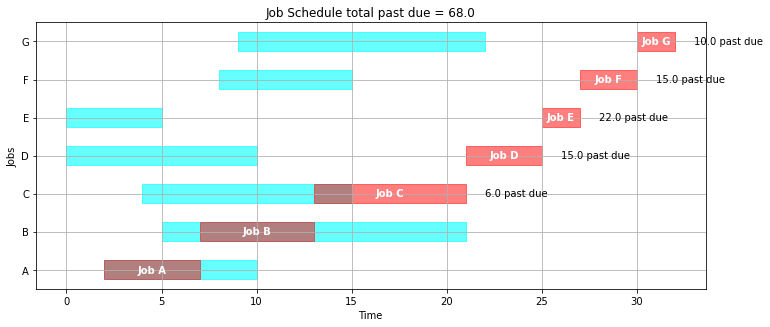

In [52]:
import matplotlib.pyplot as plt

def gantt(jobs, schedule=None):

    bw = 0.25  # bar_width
    fig, ax = plt.subplots(1, 1, figsize=(12, 0.7*len(jobs.index)))
    
    # plot release/due windows
    for k, job in enumerate(jobs.index):
        x = jobs.loc[job, "release"]
        y = jobs.loc[job, "due"]
        ax.fill_between([x, y], [k-bw, k-bw], [k+bw, k+bw], color="cyan", alpha=0.6)
        
    # if no schedule, perform jobs in order given in jobs
    if schedule is None:
        schedule = pd.DataFrame(index=jobs.index)
        t = 0
        for job in jobs.index:
            t = max(t, jobs.loc[job]["release"])
            schedule.loc[job, "start"] = t
            t += jobs.loc[job, "duration"]
            schedule.loc[job, "finish"] = t
            schedule.loc[job, "past"] = max(0, t - jobs.loc[job, "due"])  
    
    # plot job schedule
    for k, job in enumerate(schedule.index):
        x = schedule.loc[job, "start"]
        y = schedule.loc[job, "finish"]
        ax.fill_between([x, y], [k-bw, k-bw], [k+bw, k+bw], color="red", alpha=0.5)
        ax.text((schedule.loc[job, "start"] + schedule.loc[job, "finish"])/2.0, k, 
                 "Job " + job, color="white", weight="bold",
                 ha="center", va="center")
        if schedule.loc[job, "past"] > 0:
            ax.text(schedule.loc[job, "finish"] + 1, k,
                    f"{schedule.loc[job, 'past']} past due", va="center")
        
    total_past_due = schedule["past"].sum()

    ax.set_ylim(-0.5, len(jobs.index)-0.5)
    ax.set_title(f'Job Schedule total past due = {total_past_due}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Jobs')
    ax.set_yticks(range(len(jobs.index)), jobs.index)
    ax.grid(True)
        
gantt(jobs)

## Modeling

The modeling starts by defining the problem data.

| Symbol | Description |
|:---- | :--- |
| $\text{release}_j$ | when job $j$ is available|
| $\text{duration}_j$ | how long job $j$  |
| $\text{due}_j$ | when job $j$ is due |

The essential decision variable is the time at which the job starts processing.

| Symbol | Description |
|:---- | :--- |
| $\text{start}_j$ | when job $j$ starts |
| $\text{finish}_j$ | when job $j$ finishes |
| $\text{past}_j$ | how long job $j$ is past due |

Depending on application and circumstances, one could entertain many different choices for objective function. Minimizing the number of past due jobs, or minimizing the maximum past due, or the total amount of time past due would all be appropriate objectives. The following Pyomo model minimizes the total time past due, that is

$$
\min \sum_j \text{past}_j
$$

The constraints describe the relationships amomg the decision variables. For example, a job cannot start until it is released for processing

$$
\begin{align*}
\text{start}_{j} & \geq \text{release}_{j}\\
\end{align*}
$$

Once started the processing continues until the job is finished. The finish time is compared to the due time, and the result stored the $\text{past}_j$ decision variable. These decision variables are needed to handle cases where it might not be possible to complete all jobs by the time they are due.

$$
\begin{align*}
\text{finish}_j & = \text{start}_j + \text{duration}_j \\
\text{past}_{j} & \geq \text{finish}_j - \text{due}_{j} \\
\text{past}_{j} & \geq 0
\end{align*}
$$

The final set of constraints require that no pair of jobs be operating on the same machine at the same time. For this purpose, we consider each unique pair ($i$, $j$) where the constraint $i < j$ to imposed to avoid considering the same pair twice. Then for any unique pair $i$ and $j$,  either $i$ finishes before $j$ starts, or $j$ finishes before $i$ starts. This is expressed as the family of disjuctions 

$$
\begin{align*}
\begin{bmatrix}
\text{finish}_i \leq \text{start}_j
\end{bmatrix}
& \veebar
\begin{bmatrix}
\text{finish}_j \leq \text{start}_i
\end{bmatrix}
& \forall i < j
\end{align*}
$$

This model and constraints can be directly translated to Pyomo.

,release,duration,due
A,2,5,10
B,5,6,21
C,4,8,15
D,0,4,10
E,0,2,5
F,8,3,15
G,9,2,22


,start,finish,past
A,6.0,11.0,1.0
B,14.0,20.0,0.0
C,22.0,30.0,15.0
D,2.0,6.0,0.0
E,0.0,2.0,0.0
F,11.0,14.0,0.0
G,20.0,22.0,0.0


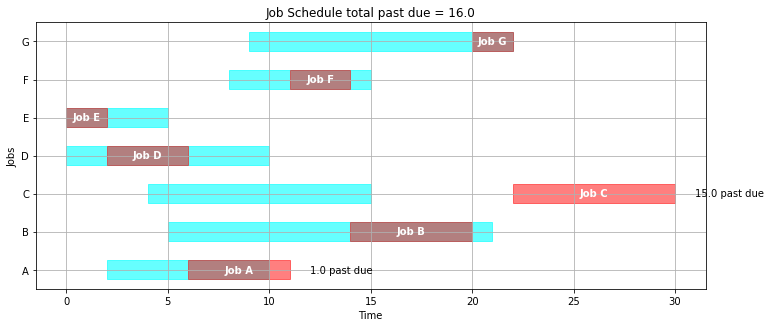

In [55]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

def build_model(jobs):

    m = pyo.ConcreteModel()

    m.JOBS = pyo.Set(initialize=jobs.index)
    m.PAIRS = pyo.Set(initialize=m.JOBS * m.JOBS, filter = lambda m, i, j: i < j)

    m.start = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, 300))
    m.finish = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, 300))
    m.past = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, 300))

    @m.Constraint(m.JOBS)
    def job_release(m, job):
        return m.start[job] >= jobs.loc[job, "release"]
    
    @m.Constraint(m.JOBS)
    def job_duration(m, job):
        return m.finish[job] == m.start[job] + jobs.loc[job, "duration"]

    @m.Constraint(m.JOBS)
    def past_due_constraint(m, job):
        return m.past[job] >= m.finish[job] - jobs.loc[job, "due"]

    @m.Disjunction(m.PAIRS, xor=True)
    def machine_deconflict(m, job_a, job_b):
        return [m.finish[job_a] <= m.start[job_b],
                m.finish[job_b] <= m.start[job_a]]
    
    @m.Objective(sense=pyo.minimize)
    def minimize_past(m):
        return sum(m.past[job] for job in m.JOBS)

    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    return m

def solve_model(m, solver_name="cbc"):
    solver = pyo.SolverFactory(solver_name)
    solver.solve(m)
    schedule = pd.DataFrame({
        "start" : {job: m.start[job]() for job in m.JOBS},
        "finish" : {job: m.finish[job]() for job in m.JOBS},
        "past" : {job: m.past[job]() for job in m.JOBS},
    })
    return schedule
    
model = build_model(jobs)
schedule = solve_model(model)

display(jobs)
display(schedule)
gantt(jobs, schedule)